## 변이형 오토인코더 분석

### 라이브러리 임포트

In [1]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

from vae_auto_encoder import VAEAutoEncoder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device')

Using cuda device


In [3]:
data_path = '../data/'
image_save_folder = './images/vae_digits/'
model_save_path = './vae_digits_model.pth'
os.makedirs(image_save_folder, exist_ok=True)

### 데이터 적재

In [4]:
train_data = datasets.MNIST(root=data_path,
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root=data_path,
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())

### 모델 만들기

In [5]:
model = VAEAutoEncoder(num_layers=4,
                       encoder_channels=[1, 32, 64, 64, 64],
                       encoder_kernel_sizes=[3, 3, 3, 3],
                       encoder_strides=[1, 2, 2, 1],
                       decoder_channels=[64, 64, 64, 32, 1],
                       decoder_kernel_sizes=[3, 3, 3, 3],
                       decoder_strides=[1, 2, 2, 1],
                       linear_sizes=[3136, 2],
                       view_size=[-1, 64, 7, 7],
                       use_batch_norm=False,
                       use_dropout=False).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)

VAEAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=3136, out_features=2, bias=True)
  (log_var_layer): Linear(in_features=3136, out_features=2, bias=True)
  (linear): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_

### 원본 그림 재구성

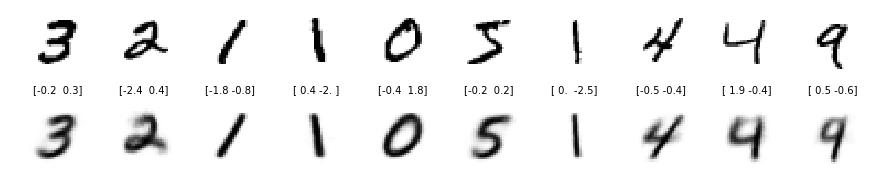

In [6]:

num_to_show = 10
indices = torch.arange(num_to_show)
test_data_10 = data_utils.Subset(test_data, indices)

test_data_loader = DataLoader(test_data_10,
                              batch_size=4,
                              shuffle=True,
                              pin_memory=True)

output_image_list = []

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

i = 0
for inputs, labels in test_data_loader:
    z_points, _, _ = model.encode(inputs.to(device))
    outputs = model.decode(z_points)
    z_points = z_points.detach().cpu().numpy()
    output_image_list.append(outputs.detach().cpu().numpy())
    
    for input, label, z_point in zip(inputs, labels, z_points):
        ax = fig.add_subplot(2, num_to_show, i + 1)
        ax.axis('off')
        ax.text(0.5, -0.35, str(np.round(z_point, 1)), fontsize=10,
                ha='center', transform=ax.transAxes)
        ax.imshow(input[0], cmap='gray_r')
        i += 1
    
output_image_ndarray = np.vstack(output_image_list)

for i in range(num_to_show):
    img = output_image_ndarray[i].squeeze()
    ax = fig.add_subplot(2, num_to_show, i + num_to_show + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

plt.savefig(os.path.join(image_save_folder, 'reconstruct.png'))

엔 코더 씨의 전시벽

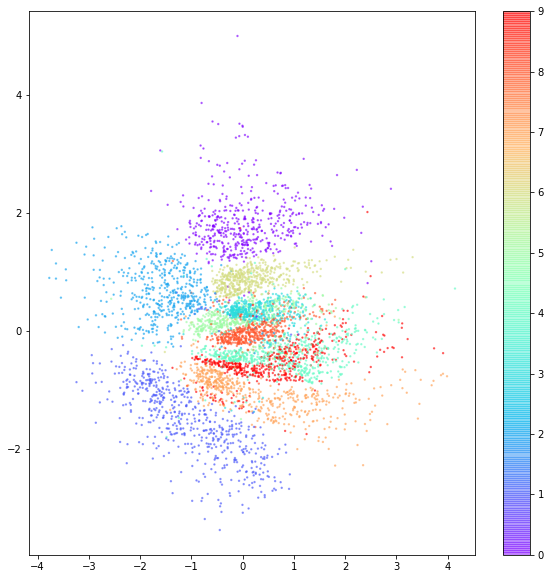

In [7]:
num_data = 5000
fig_size = 10
z_point_list = []
label_list = []

indices = torch.arange(num_data)
test_data_subset = data_utils.Subset(test_data, indices)

test_data_loader = DataLoader(dataset=test_data_subset,
                               batch_size=32,
                               shuffle=True,
                               num_workers=4,
                               pin_memory=True)

for inputs, labels in test_data_loader:
    inputs = inputs.to(device)
    z_points, _, _ = model.encode(inputs)
    
    z_point_list.append(z_points.detach().cpu().numpy())
    label_list.append(labels.numpy())
    
z_points = np.vstack(z_point_list)
labels = np.hstack(label_list)
z_points = z_points.reshape(-1, 2)

plt.figure(figsize=(fig_size, fig_size))
plt.scatter(z_points[:, 0], z_points[:, 1], cmap='rainbow', c=labels,
            alpha=0.5, s=2)
plt.colorbar()
plt.savefig(os.path.join(image_save_folder, 'scatter.png'))

### 새로 생성한 미술 전시품

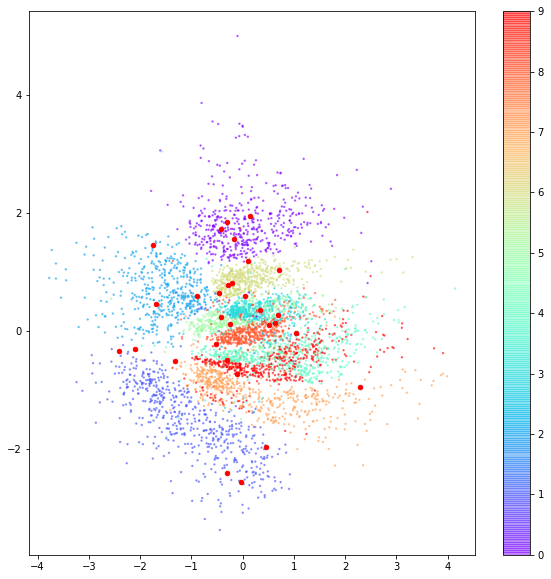

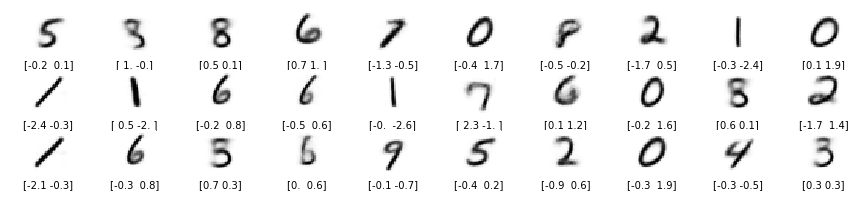

In [8]:
fig_size = 10

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(fig_size, fig_size))
plt.scatter(z_points[:, 0], z_points[:, 1], cmap='rainbow', c=labels,
            alpha=0.5, s=2)
plt.colorbar()

grid_size = 10
grid_depth = 3
fig_size = 15

x = np.random.normal(size=grid_size * grid_depth)
y = np.random.normal(size=grid_size * grid_depth)
z_grids = torch.tensor(np.array(list(zip(x, y))), dtype=torch.float)
reconst = model.decode(z_grids.to(device))
reconst = reconst.detach().cpu().numpy()

plt.scatter(z_grids[:, 0], z_grids[:, 1], c='red', alpha=1, s=20)
plt.savefig(os.path.join(image_save_folder, 'generated_image_points.png'))
plt.show()

fig = plt.figure(figsize=(fig_size, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    round_z_grid = np.round(z_grids[i].tolist(), 1)
    text = str(round_z_grid)
    ax = fig.add_subplot(grid_depth, grid_size, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, text, fontsize=10,
            ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, 0, :, :], cmap='Greys')
    
plt.savefig(os.path.join(image_save_folder, 'generated_images.png'))

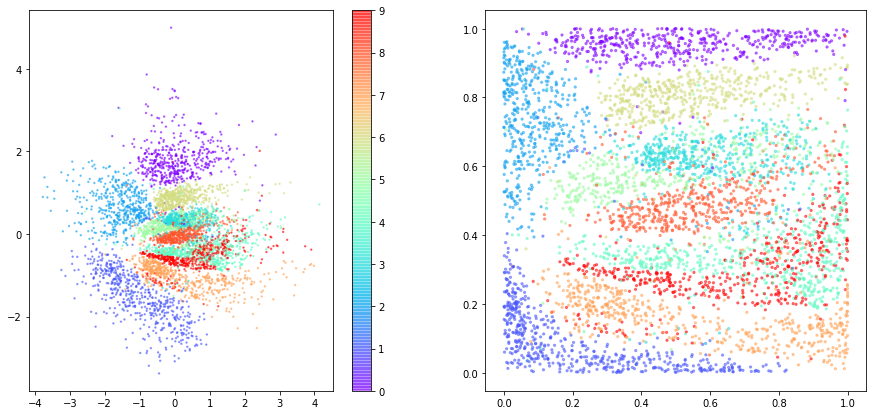

In [9]:
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0], z_points[:, 1], cmap='rainbow',
                    c=labels, alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0], p_points[:, 1], cmap='rainbow',
                    c=labels, alpha=0.5, s=5)

plt.savefig(os.path.join(image_save_folder, 'norm_cdf_distribution.png'))

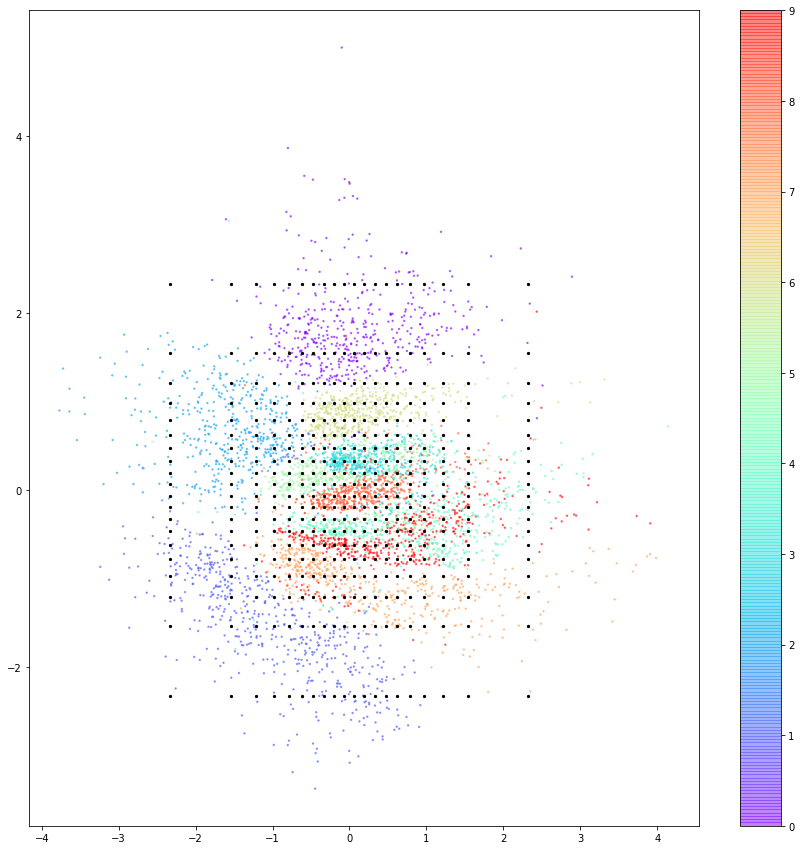

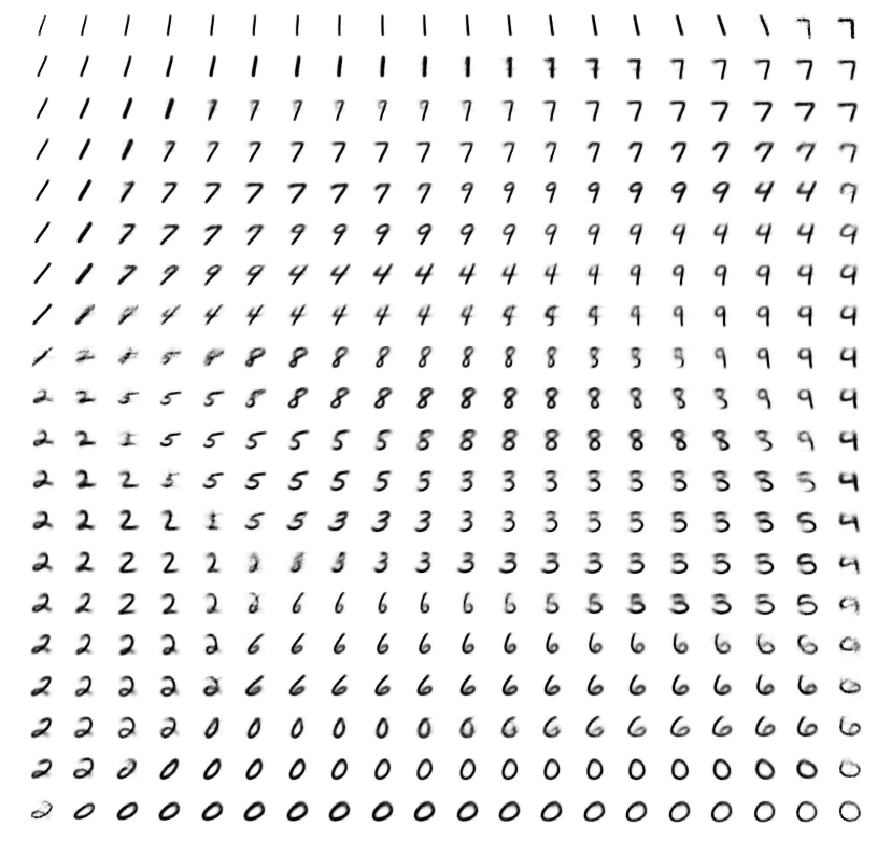

In [10]:
n_to_show = 5000
grid_size = 20

plt.figure(figsize=(fig_size, fig_size))
plt.scatter(z_points[:, 0], z_points[:, 1], cmap='rainbow', c=labels,
            alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grids = torch.tensor(np.array(list(zip(xv, yv))), dtype=torch.float)
reconst = model.decode(z_grids.to(device))
reconst = reconst.detach().cpu().numpy()

plt.scatter(z_grids[:, 0], z_grids[:, 1], c='black', alpha=1, s=5)
plt.savefig(os.path.join(image_save_folder, 'generated_image_on_grid_points.png'))
plt.show()

fig = plt.figure(figsize=(fig_size, fig_size))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size ** 2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis('off')
    ax.imshow(reconst[i, 0, :, :], cmap='Greys')
    
plt.savefig(os.path.join(image_save_folder, 'generated_images_on_grid.png'))